In [1]:
import torch # type: ignore
from torch import nn # type: ignore
from torch.utils.data import DataLoader # type: ignore
import torchvision # type: ignore
from torchvision import transforms # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [2]:
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

PyTorch version: 2.4.1+cu124
torchvision version: 0.19.1+cu124


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
cifar10 = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)

class_names = cifar10.classes
print(class_names)

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
def get_dataloader(transform: torchvision.transforms,
                   batch_size: int,
                   num_workers: int):
    trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)

    train_dataloader = DataLoader(dataset= trainset, batch_size = batch_size, shuffle= True, num_workers = num_workers)
    test_dataloader = DataLoader(dataset= testset, batch_size = batch_size, shuffle= False, num_workers = num_workers)

    return train_dataloader, test_dataloader

In [9]:
import os
num_workers = os.cpu_count()

simple_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

simple_cnn_train_dataloader, simple_cnn_test_dataloader = get_dataloader(simple_transforms, 32, num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
import random

def inspect_images(dataloader: torch.utils.data.DataLoader,
                   k: int,
                   seed = 42):
    batch = next(iter(dataloader))
    images, labels = batch

    image_list = [img for img in images]
    label_list = [label for label in labels]
    torch.manual_seed(42)
    random.seed(42)

    combined = list(zip(image_list, label_list))
    random_samples = random.sample(combined, k)

    fig, axs = plt.subplots(1,5, figsize=(15,3))

    for ax, (img, label) in zip(axs, random_samples):
      ax.imshow((img.permute(1,2,0)))
      ax.set_title(f'Label: {class_names[label]}')
      ax.axis('off')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.67058825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.77254903].


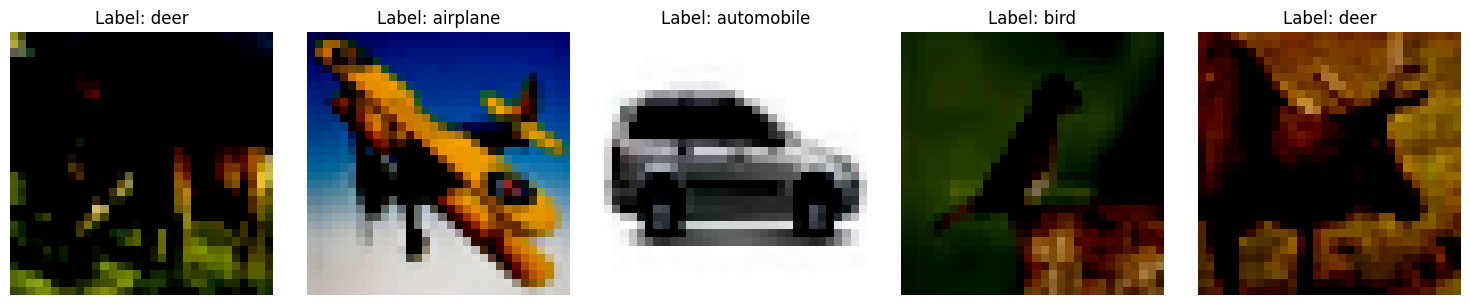

In [16]:
inspect_images(simple_cnn_train_dataloader,
               5)

# Training function

In [29]:
def train_model(trainloader: torch.utils.data.DataLoader,
                testloader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn : torch.nn.Module,
                optimizer : torch.optim.Optimizer,
                epochs : int = 3,
                device = device,
                seed = 42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  model.to(device)
  model.train()
  for epoch in range(epochs):
      print(f'epoch {epoch+1}')
      train_loss = 0
      for i, (X, y) in enumerate(trainloader):
          X, y = X.to(device), y.to(device)
          y_logits = model(X)
          loss = loss_fn(y_logits, y)
          train_loss += loss
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      train_loss /= len(trainloader)

      test_loss, test_acc = 0, 0
      model.eval()
      with torch.inference_mode():
        for X,y in testloader:
          X, y = X.to(device), y.to(device)
          y_logits = model(X)
          loss = loss_fn(y_logits, y)
          test_loss += loss
          y_pred = torch.argmax(y_logits, dim = 1)
          correct = torch.eq(y_pred, y).sum().item()
          acc = correct / len(y_pred) * 100
          test_acc += acc

        test_loss /= len(testloader)
        test_acc /= len(testloader)

      print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
      

# Loss and Optimizer

In [12]:
def initialize_lossfn_and_optimizer(model: torch.nn.Module):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = model.parameters(),
                                 lr = 0.001)
    return loss_fn, optimizer

# Simple CNN

In [13]:
class CNN(nn.Module):
  def __init__(self,
               input_shape : int,
               output_shape: int,
               hidden_units: int):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  padding = 1,
                  stride = 1),  # (B, hidden_units, [(input - kernel + 2padding) / stride + 1])
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  padding = 1,
                  stride = 1),  # (B, hidden_units, [(input - kernel + 2padding) / stride + 1])
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)  # (B, hidden_units, [(input - kernel) / stride + 1])
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 2,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 10*9*9,
                  out_features = output_shape)
    )
  def forward(self, x):
    return self.classifier(self.block2(self.block1(x)))

cnn = CNN(3, 10, 10).to(device)
# cnn = torch.compile(cnn)
dummy_tensor = torch.rand(size=(3,32,32))
y_logits = cnn(dummy_tensor.unsqueeze(dim = 0).to(device))
print(y_logits.detach().cpu().numpy())

[[-0.03565965 -0.13378124 -0.10335168 -0.00243631 -0.03570836  0.05868932
  -0.01296816  0.07398125  0.12694821 -0.09966342]]


In [14]:
simple_cnn_loss_fn, simple_cnn_optimizer = initialize_lossfn_and_optimizer(model = cnn)

train_model(trainloader = simple_cnn_train_dataloader,
            testloader = simple_cnn_test_dataloader,
            model= cnn,
            loss_fn = simple_cnn_loss_fn,
            optimizer= simple_cnn_optimizer,
            epochs= 3,
            device= device,
            seed = 42)

# Pretrained models

In [15]:
try:
  from torchinfo import summary # type: ignore
except:
  !pip install torchinfo
  from torchinfo import summary # type: ignore

In [16]:
def summarize_model(model):
    model_summary = summary(model= model,
            input_size= (1,3,224,224),
            col_names=['input_size', 'output_size','num_params','trainable'],
            col_width= 20,
            verbose= 0,
            row_settings= ['var_names'])

    print(model_summary)

## 1. AlexNet

In [21]:
def create_model(name: str, version: str = 'DEFAULT', class_names=None):
    # Get the weight class from the weight_name 
    weights_class = getattr(torchvision.models, name + '_Weights', None)
    if weights_class is None:
        raise ValueError(f"Weight '{name}_Weights' is invalid or does not exist.")
    
    # Get the specific version of the weight (e.g., DEFAULT, IMAGENET1K_V1)
    weights = getattr(weights_class, version, None)
    if weights is None:
        raise ValueError(f"Version '{version}' is not available for '{name}_Weights'.")
    
    # Get the model class from the model_name string
    model_class = getattr(torchvision.models, name.lower(), None)
    if model_class is None:
        raise ValueError(f"Model '{name.lower()}' is invalid or does not exist.")
    
    # Initialize the model with the specified weights
    model = model_class(weights=weights)
    
    # Get the transform associated with the weights
    transform = weights.transforms()

    # Freeze all parameters to prevent them from being trained
    for param in model.parameters():
        param.requires_grad = False

    # Step to find the last layer (output layer)
    def find_last_layer(model):
        # Traverse through all named children in reverse order to find the last layer
        *_, last_name, last_layer = list(model.named_children())[-1]
        return last_name, last_layer

    # Find the last layer of the model
    last_name, last_layer = find_last_layer(model)

    # Replace the output layer's number of classes
    if isinstance(last_layer, nn.Sequential):
        in_features = last_layer[-1].in_features
        new_layer = nn.Linear(in_features, len(class_names)) # Replace the last layer in the model
        last_layer[-1] = new_layer
        setattr(model, last_name, last_layer)
    else:
        in_features = last_layer.in_features
        new_layer = nn.Linear(in_features, len(class_names))
        setattr(model, last_name, new_layer)  # Replace the last layer in the model
    
    return model, transform


In [25]:
alexnet, alexnet_transform = create_model(
    name="AlexNet",
    class_names=class_names
)

In [33]:
summarize_model(alexnet)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [1, 3, 224, 224]     [1, 10]              --                   Partial
├─Sequential (features)                  [1, 3, 224, 224]     [1, 256, 6, 6]       --                   False
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 55, 55]      (23,296)             False
│    └─ReLU (1)                          [1, 64, 55, 55]      [1, 64, 55, 55]      --                   --
│    └─MaxPool2d (2)                     [1, 64, 55, 55]      [1, 64, 27, 27]      --                   --
│    └─Conv2d (3)                        [1, 64, 27, 27]      [1, 192, 27, 27]     (307,392)            False
│    └─ReLU (4)                          [1, 192, 27, 27]     [1, 192, 27, 27]     --                   --
│    └─MaxPool2d (5)                     [1, 192, 27, 27]     [1, 192, 13, 13]     --                   --
│    └─Conv2d (6

In [26]:
alexnet_traindataloader, alexnet_testdataloader = get_dataloader(transform= alexnet_transform,
                                                                    batch_size= 32,
                                                                    num_workers= num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
alexnet_lossfn, alexnet_optimizer = initialize_lossfn_and_optimizer(model=alexnet)

In [30]:
train_model(trainloader = alexnet_traindataloader,
            testloader = alexnet_testdataloader,
            model= alexnet,
            loss_fn = alexnet_lossfn,
            optimizer= alexnet_optimizer,
            epochs= 5,
            device= device,
            seed = 42)

epoch 1

Train loss: 0.78460 | Test loss: 0.61819, Test acc: 78.75%

epoch 2

Train loss: 0.51981 | Test loss: 0.58283, Test acc: 80.69%

epoch 3

Train loss: 0.45866 | Test loss: 0.53445, Test acc: 82.34%

epoch 4

Train loss: 0.41586 | Test loss: 0.57655, Test acc: 81.37%

epoch 5

Train loss: 0.38001 | Test loss: 0.61624, Test acc: 80.83%



## 2. VGGNet

In [31]:
vgg, vgg_transform = create_model(
    name='VGG11',
    class_names=class_names
)

In [32]:
summarize_model(vgg)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 10]              --                   Partial
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   False
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    (1,792)              False
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (2)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (3)                        [1, 64, 112, 112]    [1, 128, 112, 112]   (73,856)             False
│    └─ReLU (4)                          [1, 128, 112, 112]   [1, 128, 112, 112]   --                   --
│    └─MaxPool2d (5)                     [1, 128, 112, 112]   [1, 128, 56, 56]     --                   --
│    └─Conv2d (6

In [24]:
vgg_traindataloader, vgg_testdataloader = get_dataloader(transform = vgg_transform,
                                                         batch_size = 32,
                                                         num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
vgg_loss_fn, vgg_optimizer = initialize_lossfn_and_optimizer(vgg)

train_model(trainloader = vgg_traindataloader,
            testloader = vgg_testdataloader,
            model= vgg,
            loss_fn = vgg_loss_fn,
            optimizer= vgg_optimizer,
            epochs= 5,
            device= device,
            seed = 42)

epoch 1

Train loss: 0.93678 | Test loss: 0.58035, Test acc: 82.06%

epoch 2

Train loss: 0.33561 | Test loss: 0.46785, Test acc: 84.93%

epoch 3

Train loss: 0.17320 | Test loss: 0.70604, Test acc: 84.48%



## 3. GoogLeNet

In [36]:
googlenet, googlenet_transform = create_model(name='GoogLeNet', class_names=class_names)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\longt/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:17<00:00, 2.93MB/s]


In [37]:
summarize_model(googlenet)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [1, 3, 224, 224]     [1, 10]              --                   Partial
├─BasicConv2d (conv1)                    [1, 3, 224, 224]     [1, 64, 112, 112]    --                   False
│    └─Conv2d (conv)                     [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    └─BatchNorm2d (bn)                  [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─MaxPool2d (maxpool1)                   [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─BasicConv2d (conv2)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    └─Conv2d (conv)                     [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    └─BatchNorm2d (bn)                  [1, 64, 56, 56]      [1, 64, 56, 56]      (128)                False
├─Basic

In [34]:
googlenet_traindataloader, googlenet_testdataloader = get_dataloader(transform = googlenet_transform,
                                                                     batch_size = 32,
                                                                     num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
googlenet_lossfn, googlenet_optimizer = initialize_lossfn_and_optimizer(googlenet)

train_model(trainloader = googlenet_traindataloader,
            testloader = googlenet_testdataloader,
            model= googlenet,
            loss_fn = googlenet_lossfn,
            optimizer= googlenet_optimizer,
            epochs= 3,
            device= device,
            seed = 42)

epoch 1

Train loss: 0.94435 | Test loss: 0.71553, Test acc: 75.64%

epoch 2

Train loss: 0.64718 | Test loss: 0.65530, Test acc: 77.49%

epoch 3

Train loss: 0.60985 | Test loss: 0.66082, Test acc: 76.89%



## 4. ResNet

In [34]:
resnet, resnet_transform = create_model(name='ResNet18',
                                        class_names=class_names)

In [35]:
summarize_model(resnet)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 10]              --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    └─BasicBlock (0)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (36,864)             False
│    │    

In [29]:
resnet_traindataloader, resnet_testdataloader = get_dataloader(transform = resnet_transform,
                                                               batch_size = 32,
                                                               num_workers = num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
resnet_lossfn, resnet_optimizer = initialize_lossfn_and_optimizer(resnet)

train_model(trainloader = resnet_traindataloader,
            testloader = resnet_testdataloader,
            model= resnet,
            loss_fn = resnet_lossfn,
            optimizer= resnet_optimizer,
            epochs= 3,
            device= device,
            seed = 42)

epoch 1

Train loss: 0.88348 | Test loss: 0.69015, Test acc: 76.55%

epoch 2

Train loss: 0.65698 | Test loss: 0.66284, Test acc: 77.27%

epoch 3

Train loss: 0.63320 | Test loss: 0.65707, Test acc: 77.27%

